In [59]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

In [60]:
np.set_printoptions(sign=' ', linewidth=100, precision=4, suppress=True)
plt.style.use('dark_background')

In [98]:
@jit
def laplacian_1d(n):
    return np.diag(2 * np.ones(n - 2)) + \
           np.diag(-np.ones(n - 3), 1) + \
           np.diag(-np.ones(n - 3), -1)

In [99]:
@jit
def laplacian_2d(n):
    return np.kron(np.eye(n - 2), laplacian_1d(n)) + \
           np.kron(laplacian_1d(n), np.eye(n - 2))

In [101]:
@jit
def jacobi(A, b, x, N=500):
    D = np.diag(A)
    R = A - np.diag(D)
    for i in range(N):
        x = (b - np.dot(R,x)) / D
    return x

In [119]:
@jit
def gauss_seidel(A, b, x, w=1, max_iter=500):
    D = np.diag(np.diag(A))
    R = A - D
    L, U = np.tril(R), np.triu(R)
    M = D + L
    N = M - A
    
    M_inv = np.linalg.inv(M)
    M_inv_dot_N = np.dot(M_inv, N)
    M_inv_dot_b = np.dot(M_inv, b)

    for i in range(max_iter):
        x = np.dot(M_inv_dot_N, x) + M_inv_dot_b
    return x

In [105]:
@jit
def sor(A, b, x, w=1, max_iter=500):
    D = np.diag(np.diag(A))
    R = A - D
    L, U = np.tril(R), np.triu(R)
    M = D / w + L
    N = M - A
    M_inv = np.linalg.inv(M)
    M_inv_dot_N = np.dot(M_inv, N)
    M_inv_dot_b = np.dot(M_inv, b)

    for i in range(max_iter):
        x = np.dot(M_inv_dot_N, x) + M_inv_dot_b
    return x

In [106]:
@jit
def ssor(A, b, x, w=1, max_iter=500):
    D = np.diag(np.diag(A))
    R = A - D
    L, U = np.tril(R), np.triu(R)
    M = (1 / (w * (2 - w))) * np.dot(np.dot(D + w * L, np.linalg.inv(D)), (D + w * U))
    N = M - A
    M_inv = np.linalg.inv(M)
    M_inv_dot_N = np.dot(M_inv, N)
    M_inv_dot_b = np.dot(M_inv, b)

    for i in range(max_iter):
        x = np.dot(M_inv_dot_N, x) + M_inv_dot_b
    return x

# Problem 1
Use the starter program `capacitor_Jacobi.py` (or its Matlab version, or your equivalent program) to solve the Laplace equation for a parallel-plate capacitor using the Jacobi relaxation algorithm (the Matlab version has two source files, `capacitor_Jacobi.m` and `capacitor_update_Jacobi.m`). In the z direction, the plates are assumed to extend from $z=−\infty\to\infty$ (translational symmetry), so the problem is only two-dimensional. Calculate and plot the potential surfaces, equipotential contours and the electric field (cf.pp.140-141 in the textbook). How many iterations (sweeps through the lattice) are required as a function of the mesh size to reach a given level of accuracy? At fixed mesh size, how does the total number of iterations needed depend on the desired accuracy? Compare your convergence results with the theoretical expectations. 

[Note] You need to add the contour plot and the E field calculation to the starter program. This can be done either by first writing the data to file and then post-processing that with your favorite 3D plotting program (for example, gnuplot, available from www.gnuplot.info), or directly from Python using the contour and quiver functions for contour plots and vector fields from the mplot3d package (Matlab has built-in functions of the same name, look those up in Help). Be careful about how 2D matrices are plotted by these programs as the row and column indices might mean something different from what you have expected.

### Parameters

In [203]:
N = 500
V = 2
Li, Lj = 1, 5
n = 50
skip = int(n/25)

### Setup

In [204]:
i = np.linspace(0, Li, n)
j = np.linspace(0, Lj, n)
ii, jj = np.meshgrid(i, j, indexing='ij')

PDE = -laplacian_2d(n)

b = np.zeros_like(PDE[:,0])
b[:n-2] = np.repeat(-V, n - 2)
b[-n+2:] = np.repeat(V, n - 2)

x_init = np.random.random(b.size)

### Simulation

In [205]:
x = jacobi(PDE, b, x_init)

### Post-Analysis

In [206]:
A = np.zeros((n, n))
A[0, :] = V * np.ones(n)
A[-1, :] = -V * np.ones(n)
A[1:-1,1:-1] = x.reshape((n-2,n-2))

grad_A_i, grad_A_j = np.gradient(A, i, j)

### Plotting

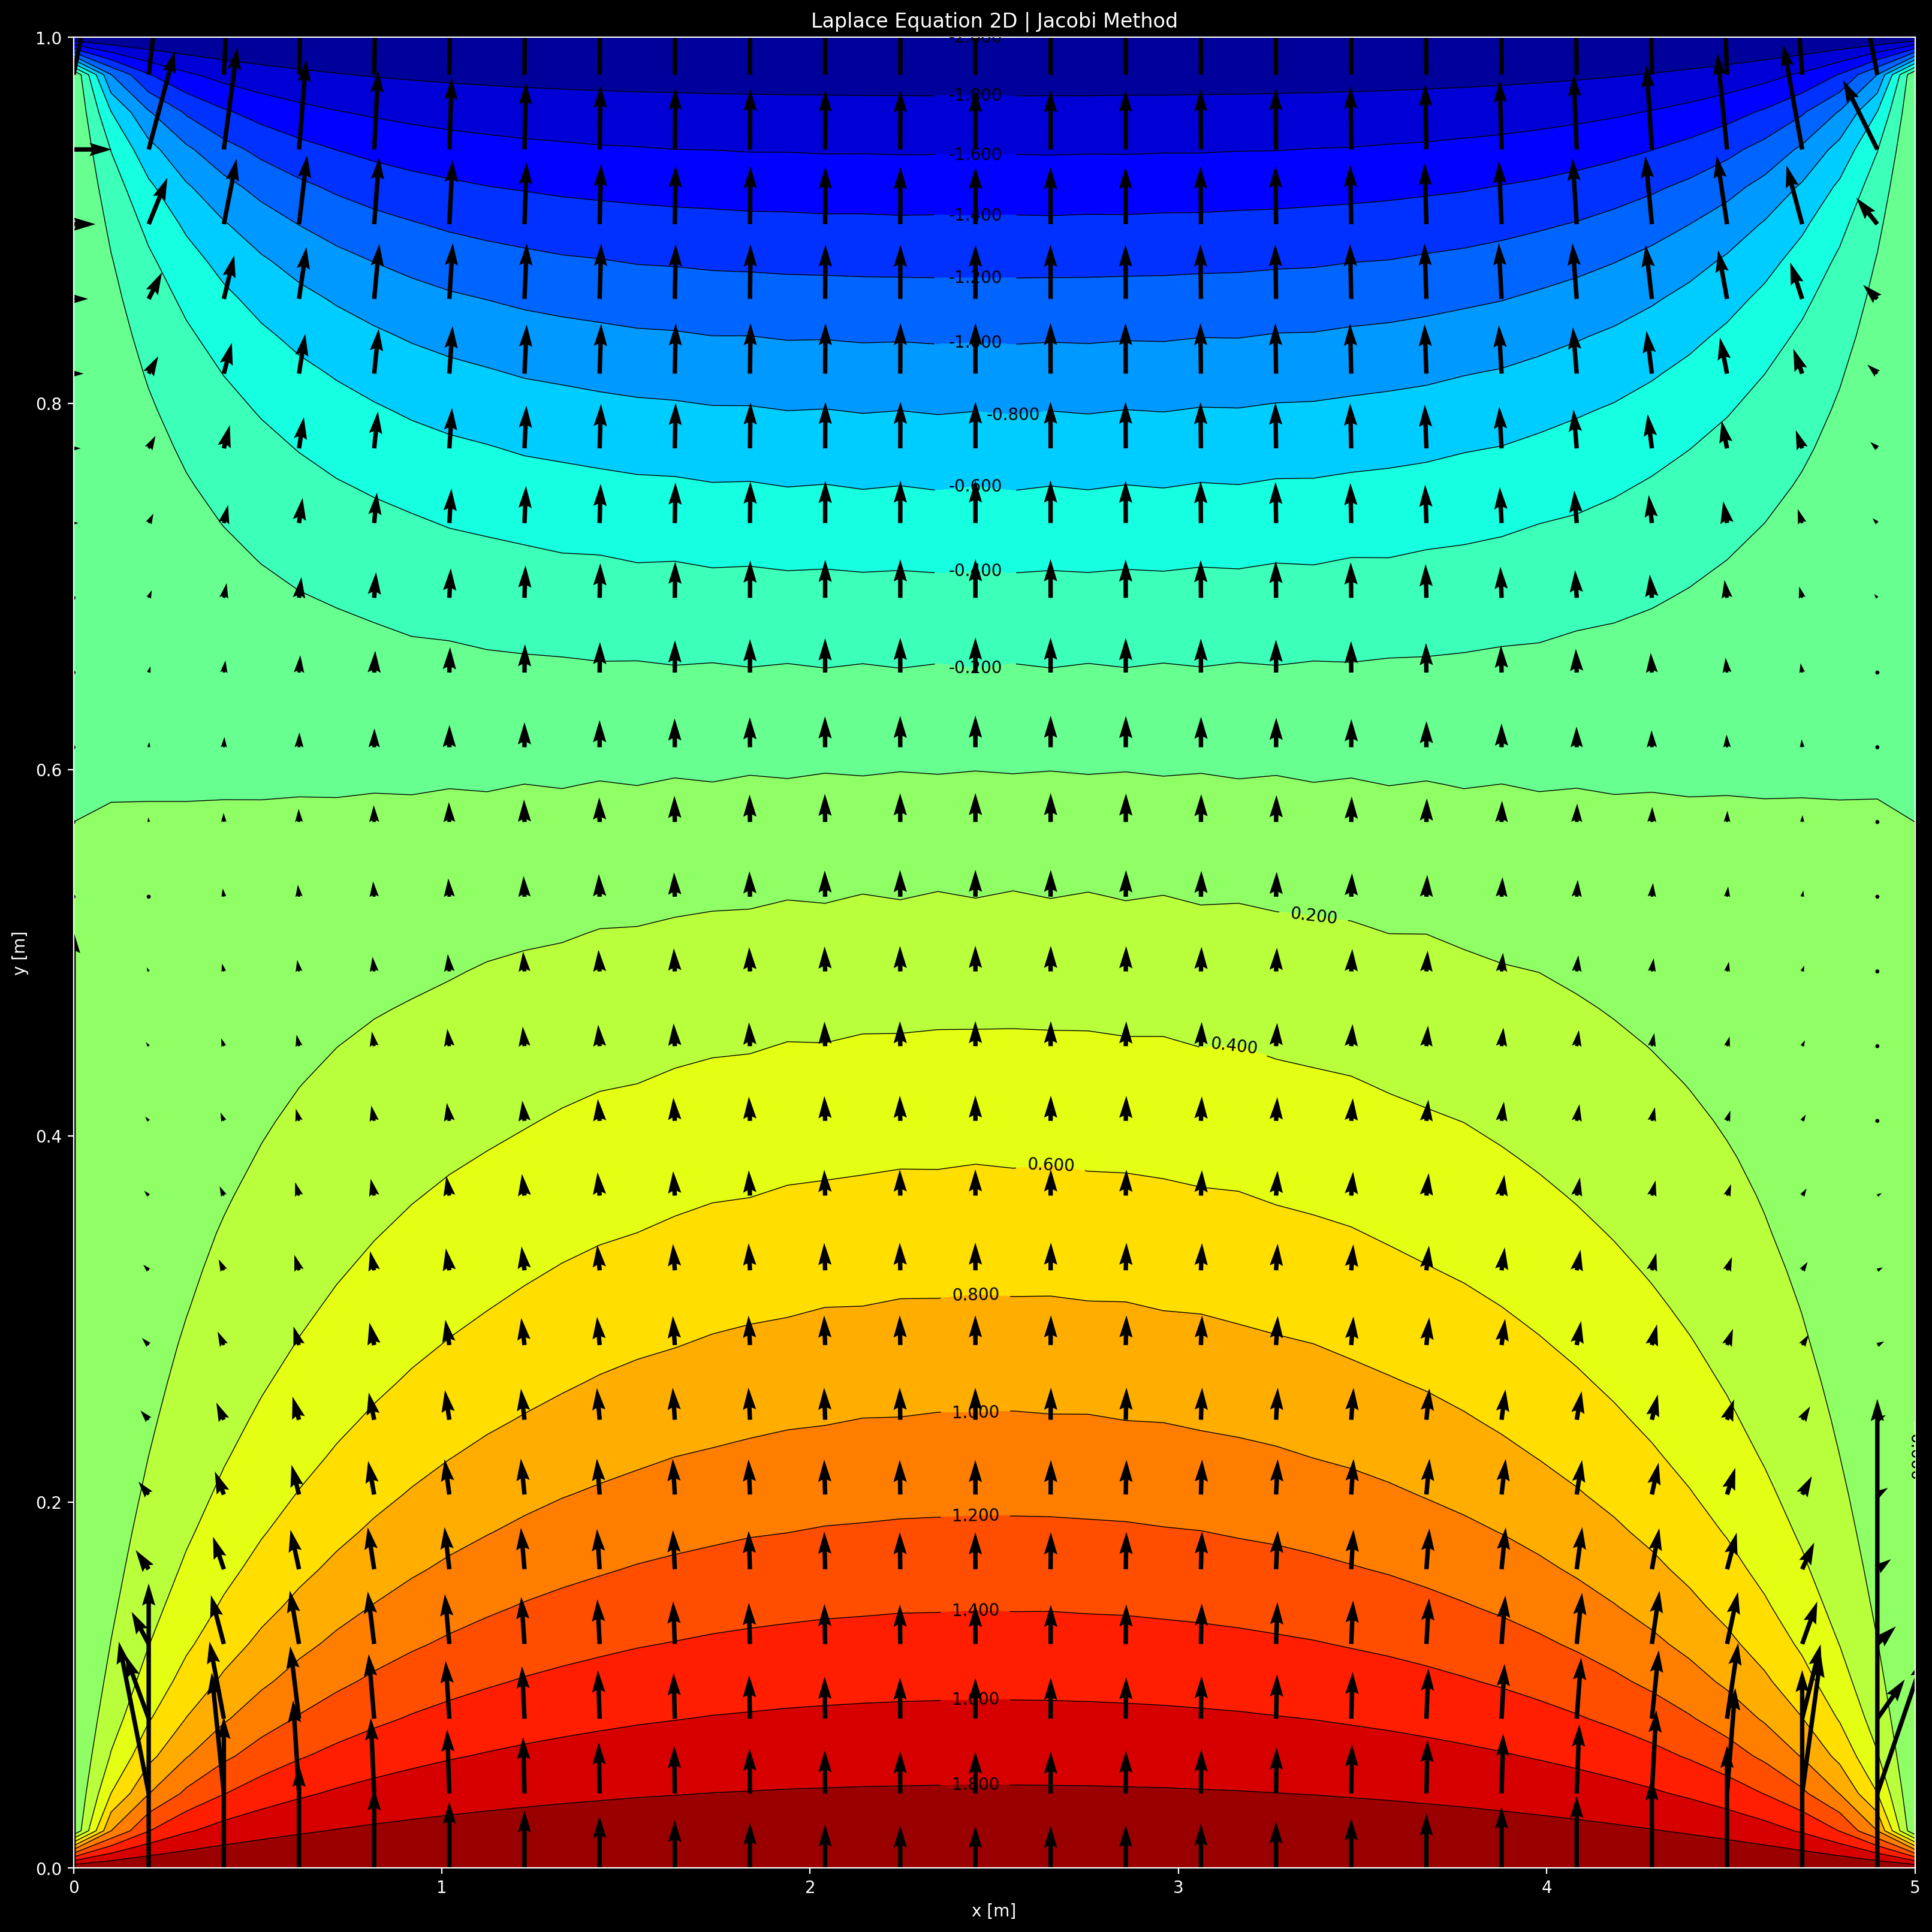

In [213]:
fig, ax = plt.subplots(1,1, figsize=(16,16), dpi=200, constrained_layout=True)
contour = ax.contourf(jj, ii, A, levels=20, linestyles = 'solid', cmap=plt.cm.jet)
contour_lines = ax.contour(jj, ii, A, levels=20, linestyles = 'solid', linewidths=0.5, colors='k')
contour_line_labels = plt.clabel(contour_lines, colors='k')
quiver = ax.quiver(
    jj[::skip, ::skip], 
    ii[::skip, ::skip], 
    -grad_A_j[::skip, ::skip], 
    -grad_A_i[::skip, ::skip])

ax.set_title('Laplace Equation 2D | Jacobi Method')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.savefig('P1_plot.png')

# Problem 2
Implement the Gauss-Seidel method to solve the same capacitor problem as in (1). Calculate the potential and analyze any differences in convergence compared to what you found for the Jacobi algorithm in (1).

### Simulation

In [208]:
x = jacobi(PDE, b, x_init)

### Post-Analysis

In [209]:
A = np.zeros((n, n))
A[0, :] = V * np.ones(n)
A[-1, :] = -V * np.ones(n)
A[1:-1,1:-1] = x.reshape((n-2,n-2))

grad_A_i, grad_A_j = np.gradient(A, i, j)

### Plotting

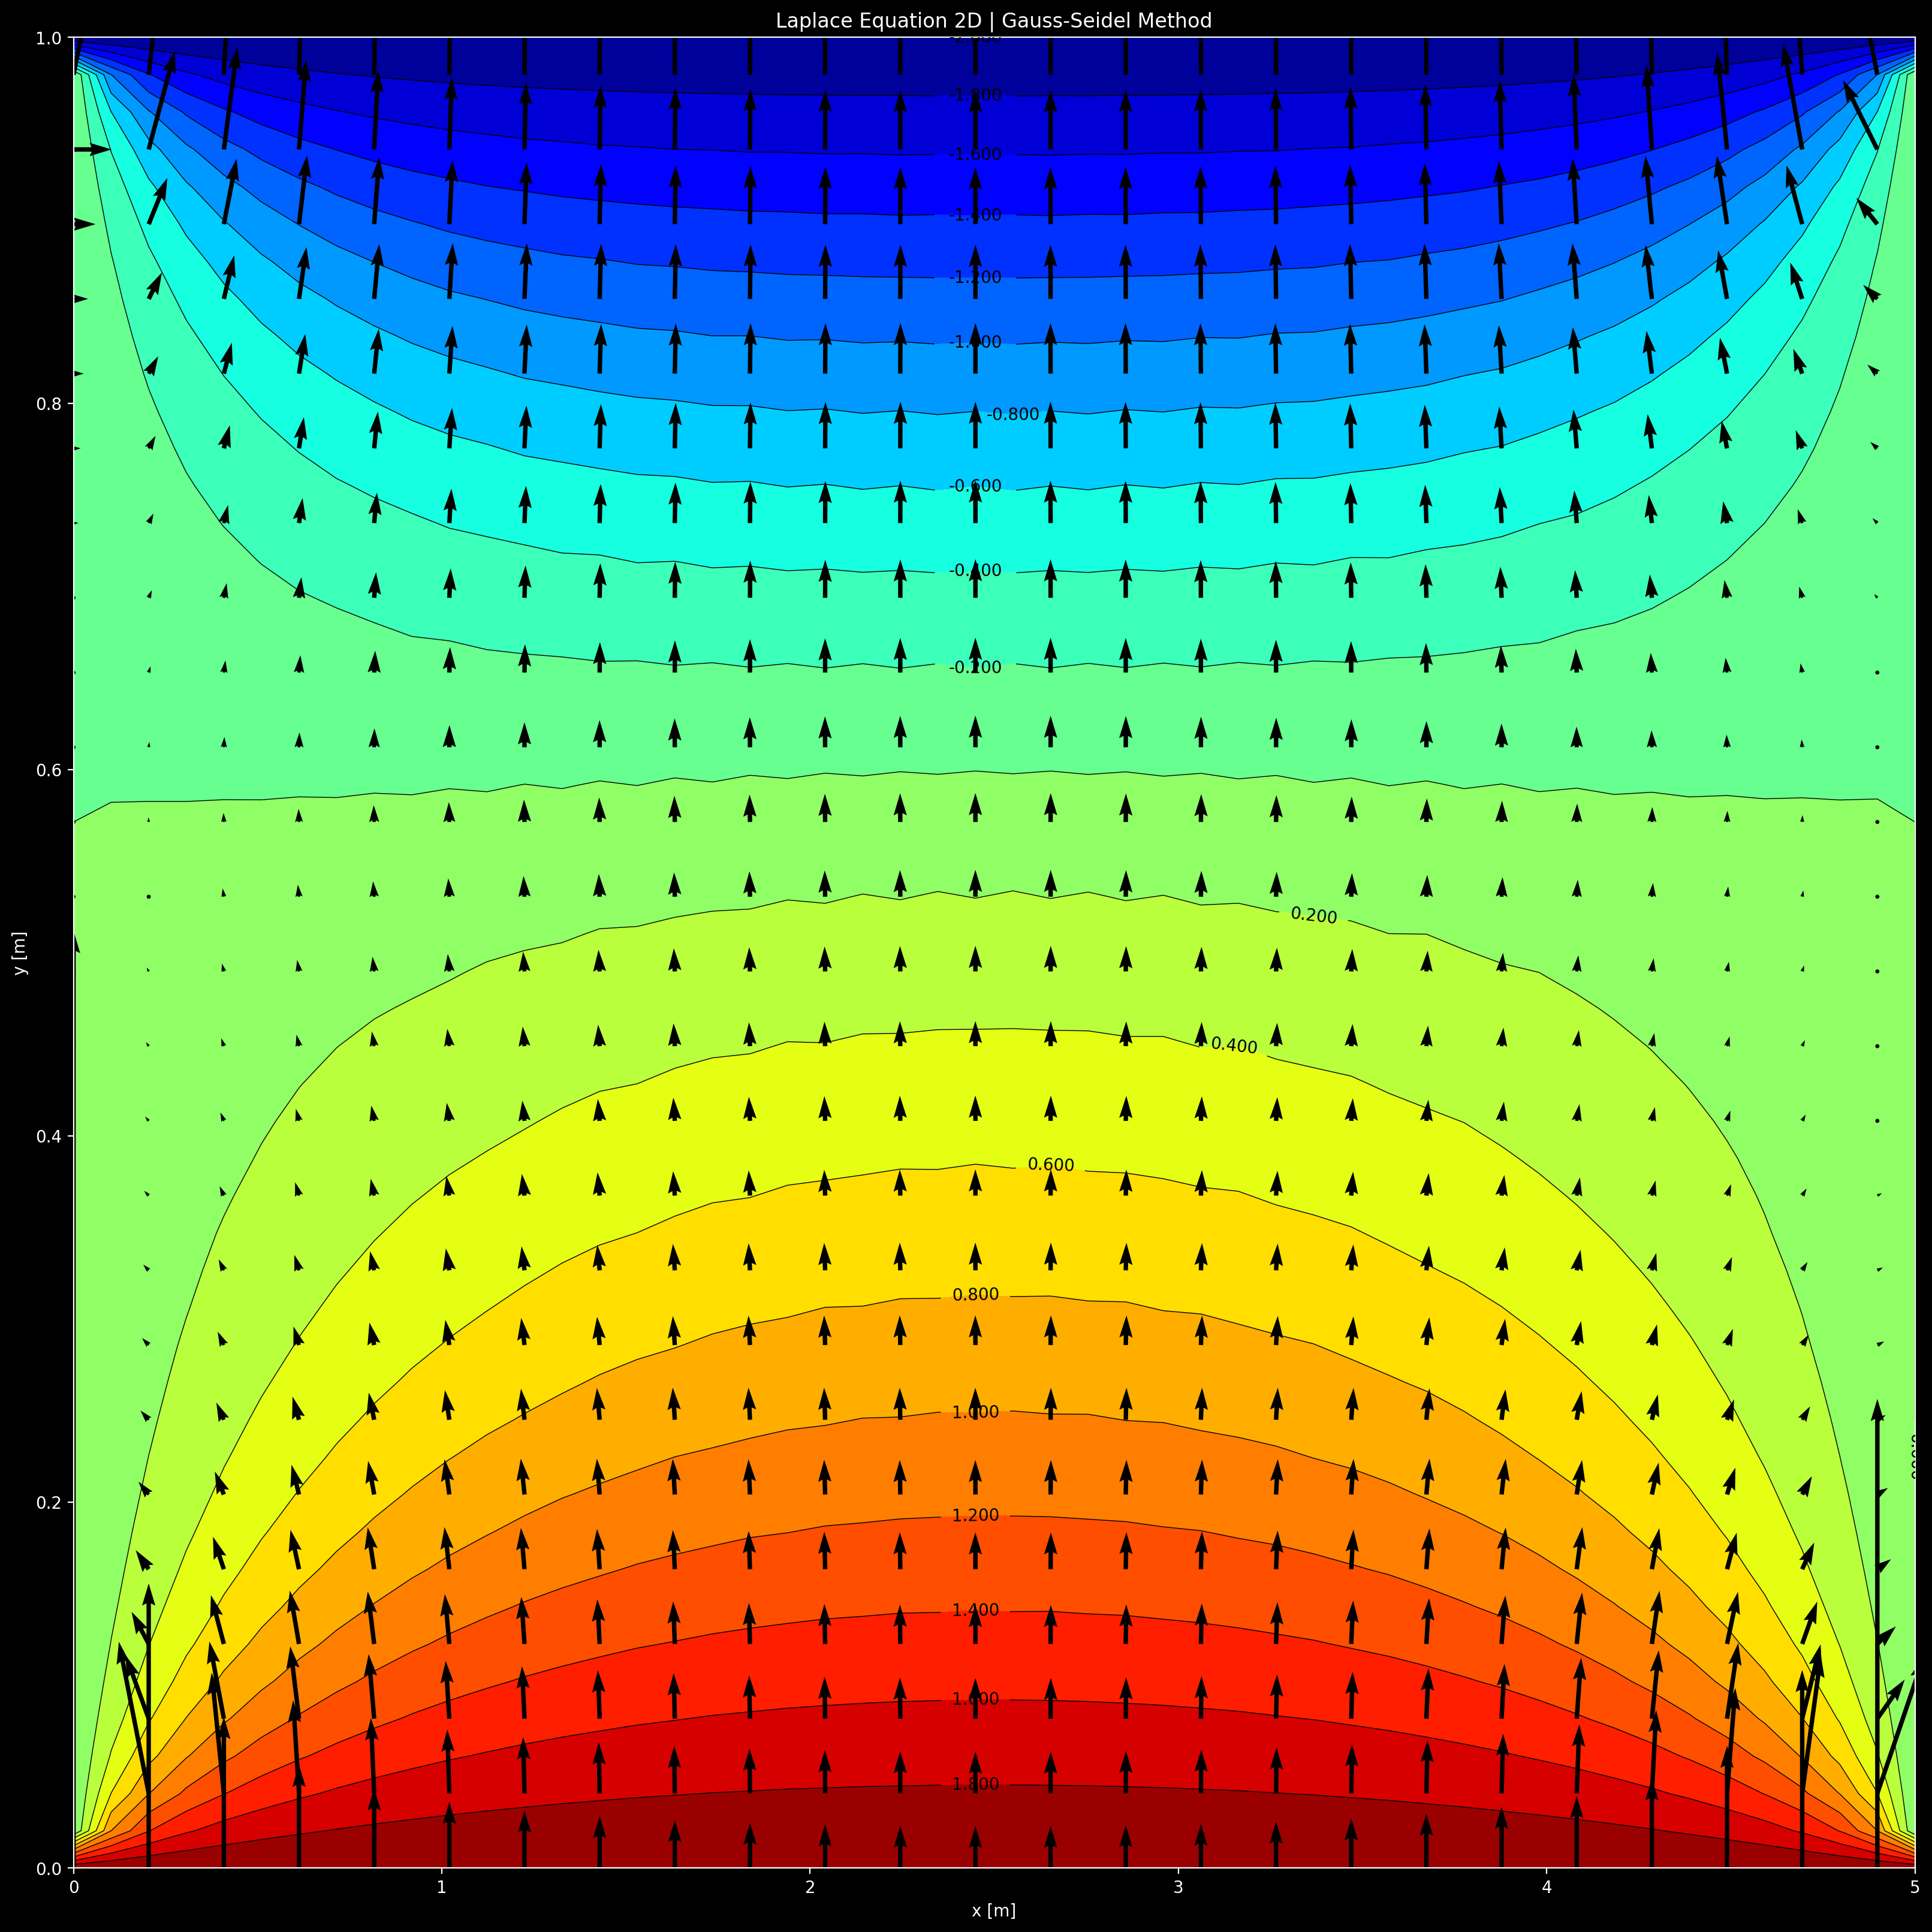

In [212]:
fig, ax = plt.subplots(1,1, figsize=(16,16), dpi=200, constrained_layout=True)
contour = ax.contourf(jj, ii, A, levels=20, linestyles = 'solid', cmap=plt.cm.jet)
contour_lines = ax.contour(jj, ii, A, levels=20, linestyles = 'solid', linewidths=0.5, colors='k')
contour_line_labels = plt.clabel(contour_lines, colors='k')
quiver = ax.quiver(
    jj[::skip, ::skip], 
    ii[::skip, ::skip], 
    -grad_A_j[::skip, ::skip], 
    -grad_A_i[::skip, ::skip])

ax.set_title('Laplace Equation 2D | Gauss-Seidel Method')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.savefig('P2_plot.png')

# Problem 3
Numerically solve the Poisson equation for the capacitor problem in (1) by introducing a term $\frac{\rho}{\epsilon_0}$ on the right hand side of the two-dimensional Laplace equation, at your favorite location away from the capacitor and the boundaries. Calculate the electric potentials and fields in this case using any of the three methods discussed so far (see Section 5.2 for how to include charge in the calculation). Compare with theoretical expectations in limiting cases where that is possible (where you can). Explain what the constant term you added corresponds to physically in this 2D calculation; is this a true point charge?

In [211]:
# N = 1250
# V = 25
# Li, Lj = 1, 1
# Ni, Nj = 150, 250
# skip = 8

# i = np.linspace(0, Li, Ni)
# j = np.linspace(0, Lj, Nj)
# x_init = b = np.zeros(Ni)
# ii, jj = np.meshgrid(i, j, indexing='ij')

# A = np.zeros((Ni, Nj))
# A[0, :] = -V * np.ones(Nj)
# A[-1, :] = V * np.ones(Nj)

# A = run_jacobi(A, Ni, Nj, N)
# gradi, gradj = np.gradient(A, i, j)

# fig, ax = plt.subplots(1,1, figsize=(16,16), dpi=200)
# contour = ax.contourf(ii, jj, A, levels=20, linestyles = 'solid', cmap=plt.cm.hot)
# contour_lines = ax.contour(ii, jj, A, levels=20, linestyles = 'solid', linewidths=0.5, colors='k')
# contour_line_labels = plt.clabel(contour_lines, colors='k')
# quiver = ax.quiver(
#     ii[::skip, ::skip], 
#     jj[::skip, ::skip], 
#     -gradi[::skip, ::skip], 
#     -gradj[::skip, ::skip])
    
# ax.set_xlabel('x [m]')
# ax.set_ylabel('y [m]')
# plt.savefig('first_run.png')

### Program to solve arbitrary no. of equations using Matlab

The following code uses the formula 
$$x_{i}^{(k+1)}={\frac {1}{a_{ii}}}\left(b_{i}-\sum _{j<i}a_{ij}x_{j}^{(k+1)}-\sum _{j>i}a_{ij}x_{j}^{(k)}\right),\quad i,j=1,2,\ldots ,n$$

```julia
function x = gauss_seidel(A, b, x, iters)
    for i = 1:iters
        for j = 1:size(A,1)
            x(j) = (1/A(j,j)) * (b(j) - A(j,:)*x + A(j,j)*x(j));
        end
    end
end
```